# Tutorial

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os


from core.losses import CustomMSE, ASTROMERLoss, CustomBCE
from core.plot import plot_lc, plot_input_layer
from core.callbacks import get_callbacks
from core.transformer import ASTROMER
from core.metrics import CustomACC
from core.input import InputLayer
from core.data  import (create_dataset, 
                        load_records)

%load_ext autoreload
%autoreload 2

In [3]:
source = './data/raw_data/MACHO/' # lightcurves folder
metadata = 'data/raw_data/MACHO/MACHO_dataset.dat' # metadata file
target = 'data/records/macho/' # where records will be stored

### Metadata frame sample

In [4]:
meta_sample = pd.read_csv(metadata).sample(1)
meta_sample

,Unnamed: 0,Class,N,Path,Band
141,141,RRL,1195,LCs/lc_1_3932_1138_B_mjd.dat,B


### Lightcurve frame sample

In [5]:
lc_df = pd.read_csv(os.path.join(source,  meta_sample['Path'].values[0]))
lc_df.head()

,mjd,mag,errmag
0,48842.458345,-4.690,0.338
1,48845.590255,-6.412,0.443
2,48882.423356,-5.562,0.038
3,48884.469873,-4.455,0.083
4,48885.437280,-4.312,0.057


### From .csv to .record 

In [5]:
create_dataset(source, metadata, target, max_lcs_per_record=1000)

100%|██████████| 7/7 [00:18<00:00,  2.62s/it]


### Visualizing Records

In [7]:
input_len = 200 # maximum lightcurve length
batch_size = 256
dataset = load_records(target+'/train', batch_size=batch_size, input_len=input_len)

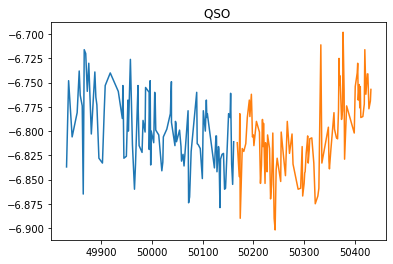

In [8]:
fig, axes = plt.subplots(1,1)
for batch in dataset:
    plot_lc(batch, axes, target, n=0)
    break

## ASTROMER

### Input Layer

In [18]:
inp_layer = InputLayer()

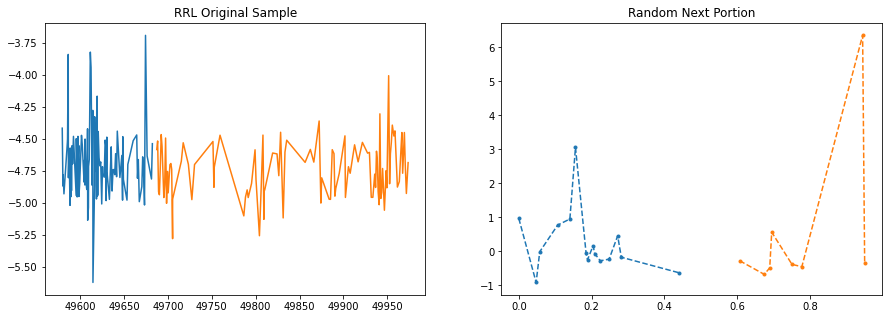

In [19]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
for batch in dataset:
    n = 0
    plot_lc(batch, axes[0], target, n=0, title='Original Sample')
    # Input transformation
    in_dict = inp_layer(batch)    
    
    plot_input_layer(in_dict, axes[1], input_len, n=0)
    break

### Training

In [35]:
exp_save = './experiments/macho_v1' # folder to save weigths and tensorboard logs

In [67]:
# Loading data
train_batches = load_records(os.path.join(target, 'train'), 
                             batch_size, 
                             input_len=input_len)
valid_batches = load_records(os.path.join(target, 'val'), 
                             batch_size, 
                             input_len=input_len)
test_batches = load_records(os.path.join(target, 'test'), 
                             batch_size, 
                             input_len=input_len)

In [37]:
# Model Instance
transformer = ASTROMER(num_layers=2, # Number of self-attention layers
                       d_model=1628, # attention dimensionality (should be divisor of num_heads)
                       num_heads=4,# Number of self-attention heads
                       dff=1024, # Dimensionality of the middle  dense layer at the end of the encoder
                       rate=0.1, # Dropout rate
                       base=10000, # Base for positional encoder
                       mask_frac=0.15, # fraction of the total to be masked
                       npp_frac=0.5, # next portion prediction rate
                       rand_frac=0.1, # 'rand_frac' of the 'mask_frac' to change [MASK] by random magnitudes
                       same_frac=0.1, # 'same_frac' of the 'mask_frac' to change [MASK] by current magnitudes
                       sep_token=102., # end of sequence token
                       cls_token=101.) # NPP class token

In [38]:
# Optimizer
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
# Model Instance
# Compile
transformer.compile(optimizer=optimizer,
                    loss=ASTROMERLoss(),
                    metrics=[CustomMSE(), CustomBCE(), CustomACC()])
# Create graph
transformer.model(batch_size).summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Serie1 (InputLayer)             [(256, 50, 3)]       0                                            
__________________________________________________________________________________________________
Serie2 (InputLayer)             [(256, 50, 3)]       0                                            
__________________________________________________________________________________________________
steps_1 (InputLayer)            [(256,)]             0                                            
__________________________________________________________________________________________________
steps_2 (InputLayer)            [(256,)]             0                                            
____________________________________________________________________________________________

In [ ]:
%%time
# Training
transformer.fit(train_batches,
                epochs=2000,
                verbose=1,
                validation_data=valid_batches,
                callbacks=get_callbacks(exp_save))

Epoch 1/2000
13/13 [==============================] - 46s 3s/step - loss: 680.1919 - MSE: 671.0397 - BCE: 6.5104 - Accuracy: 0.4910 - val_loss: 12.9241 - val_MSE: 11.7497 - val_BCE: 1.4407 - val_Accuracy: 0.5035
Epoch 2/2000
13/13 [==============================] - 35s 3s/step - loss: 14.2159 - MSE: 13.0504 - BCE: 1.1441 - Accuracy: 0.4937 - val_loss: 13.8720 - val_MSE: 13.4726 - val_BCE: 0.9366 - val_Accuracy: 0.4898
Epoch 3/2000
13/13 [==============================] - 35s 3s/step - loss: 9.2403 - MSE: 8.3689 - BCE: 0.8485 - Accuracy: 0.4969 - val_loss: 9.8053 - val_MSE: 8.8501 - val_BCE: 0.7447 - val_Accuracy: 0.5051
Epoch 4/2000
13/13 [==============================] - 35s 3s/step - loss: 7.6277 - MSE: 6.8138 - BCE: 0.7837 - Accuracy: 0.4990 - val_loss: 5.3452 - val_MSE: 4.5873 - val_BCE: 0.7437 - val_Accuracy: 0.4790
Epoch 5/2000
13/13 [==============================] - 35s 3s/step - loss: 3.8287 - MSE: 3.0666 - BCE: 0.7473 - Accuracy: 0.4888 - val_loss: 2.5081 - val_MSE: 1.7601 -

In [15]:
# Testing
metrics = transformer.evaluate(test_batches)

2/2 [==============================] - 1s 64ms/step - loss: 1290.5924 - MSE: 1514.2793 - BCE: 14.0307 - Accuracy: 0.4167


# FINETUNNING

In [28]:
from core.classifier import ASTROMERClassifier

In [75]:
classifier = ASTROMERClassifier(config='./experiments/macho_0/conf.json')

In [76]:
# Optimizer
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
# Model Instance
# Compile
classifier.compile(optimizer=optimizer,
                    loss=ASTROMERLoss(),
                    metrics=[CustomMSE(), CustomBCE(), CustomACC()])

In [79]:
classifier.model(10)

TypeError: Error converting shape to a TensorShape: Failed to convert '<KerasTensor: shape=(10, 50, 3) dtype=float32 (created by layer 'Serie1')>' to a shape: '<KerasTensor: shape=(50, 3) dtype=float32 (created by layer 'tf.__operators__.getitem_6')>'could not be converted to a dimension. A shape should either be single dimension (e.g. 10), or an iterable of dimensions (e.g. [1, 10, None])..

In [69]:
expdir = '{}/train_model.h5'.format('./experiments/macho_0')
classifier.load_weights(expdir)

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.

In [ ]:
self.astromer = self.astromer.model(10)
self.astromer.load_weights(expdir)

In [71]:
import h5py
with h5py.File(expdir, 'r') as f:
    print(f['Dense'])

<HDF5 group "/Dense" (1 members)>
